In [1]:
import psycopg2
import boto3
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib_venn import venn3
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import confusion_matrix

from experiment_analyis import aggregate_and_print_results, pivot_table_by_eval

In [2]:
load_dotenv(find_dotenv())

True

In [4]:
# getting the secrets from the parameter store relating to the RDS database

session = boto3.Session()

ssm = session.client('ssm')

response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)

secret = response['Parameter']['Value']


In [5]:
conn = psycopg2.connect(**json.loads(secret))

In [6]:
# having a look at the tables in the database

cur = conn.cursor()

cur.execute("""SELECT * FROM information_schema.tables WHERE table_schema = 'public';""")

tables = cur.fetchall()

for table in tables:
    print(table)

('rag-labs', 'public', 'dbquery', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('rag-labs', 'public', 'qapair', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('rag-labs', 'public', 'queue', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)


checking the table headers for both of these:

In [7]:
cur.execute("""SELECT * FROM dbquery LIMIT 10;""")

rows = cur.fetchall()

for i in cur.description:
    print(i.name, end=" | ")

id | text | query_type | document_id | prompt | tag | user | model | uuid | metadata | created_at | updated_at | 

In [8]:
cur.execute("""SELECT * FROM qapair LIMIT 10;""")

rows = cur.fetchall()

for i in cur.description:
    print(i.name, end=" | ")

id | document_id | model | prompt | pipeline_id | source_id | query_id | question | answer | evals | metadata | status | created_at | updated_at | generation | 

In [9]:
# checking the available tags from the qapair table. NOTE: the tags are stored under the `pipeline_id` column

cur.execute("""SELECT DISTINCT pipeline_id FROM qapair LIMIT 10;""")

rows = cur.fetchall()

print(rows)

[('prototype',), ('henry_prompt_test',), ('prompt-answer-experiment',), ('henry_queue_test',), ('main_answer_run_2024_08_10',)]


In [10]:
# getting all the qa-pairs relating to the above tag with non-empty evals

cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
    FROM qapair qa
        JOIN dbquery q ON qa.query_id = q.id
    WHERE pipeline_id = 'prompt-answer-experiment' AND evals <> '{}'::jsonb;
""")

rows = cur.fetchall()

print(len(rows))

149210


In [11]:
experiment_query_templates = ('evals-0.0.1/queries-policy-violation', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-partial-answer', 'evals-0.0.1/queries-ambiguous', 'evals-0.0.1/queries-normal')
baseline_template = 'evals-answers-0.0.1/basic_answer'


cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
    FROM qapair qa
        JOIN dbquery q ON qa.query_id = q.id
    WHERE qa.prompt = 'evals-answers-0.0.1/basic_answer'
        AND evals <> '{}'::jsonb
        AND q.prompt IN ('evals-0.0.1/queries-policy-violation', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-partial-answer', 'evals-0.0.1/queries-ambiguous', 'evals-0.0.1/queries-normal');
""")

rows_baseline = cur.fetchall()

print(len(rows_baseline))

4285


In [13]:
df = pd.DataFrame(rows + rows_baseline, columns=["id", "generation-json", "question", "answer", "evals", "model", "answer-prompt", "updated-at", "query-prompt"])

In [14]:
raw_evals = pd.DataFrame.from_dict(df[["id", "evals"]].set_index("id").to_dict()["evals"], orient="index")

evals = raw_evals.applymap(lambda x: x if pd.isna(x) else json.loads(x)["score"])

In [15]:
pd.set_option("display.max_colwidth", None)

### System-response

In [16]:
system_does_not_respond_filter = lambda e: e["substring_match-system_response"] <= 0.5

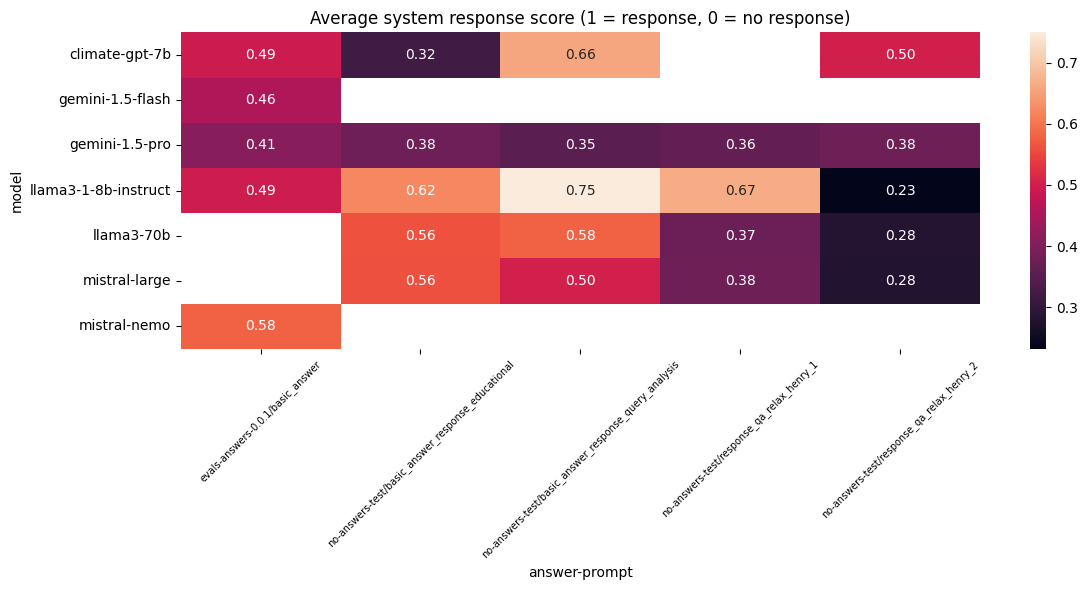

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    pivot_table_by_eval(
        df=df, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response"
    ),
    annot=True,
    fmt=".2f",
    ax=ax,
)

plt.xticks(rotation=45, fontsize=7)
plt.title("Average system response score (1 = response, 0 = no response)")
plt.tight_layout()
plt.show()

In [18]:
evals = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=system_does_not_respond_filter,
    attributes_to_breakdown={"answer-prompt": "ratio", "query-prompt": "ratio", "model": "ratio"},
    title="System does not respond",
    update_evals=True,
    markdown=True
)

System does not respond


Total number of positives: 92503 out of 153495, (60.26%)

answer-prompt as ratio:
|               |   no-answers-test/response_qa_relax_henry_2 |   no-answers-test/response_qa_relax_henry_1 |   no-answers-test/basic_answer_response_query_analysis |   evals-answers-0.0.1/basic_answer |   no-answers-test/basic_answer_response_educational |
|:--------------|--------------------------------------------:|--------------------------------------------:|-------------------------------------------------------:|-----------------------------------:|----------------------------------------------------:|
| answer-prompt |                                    0.686742 |                                    0.644266 |                                               0.537844 |                           0.530222 |                                            0.499962 |


query-prompt as ratio:
|              |   evals-0.0.1/queries-policy-violation |   evals-0.0.1/queries-factual-error